# On Mahalanobis distance in functional settings
Work by Berrendero, et.al. ([link](https://arxiv.org/abs/1803.06550))

The main idea:
> Given two functions $x, m \in L^2[0,1]$, just approximate them by two other functions $x_\alpha, m_\alpha \in \mathcal{H}(K)$ and calculate the distance $\vert\vert x_\alpha - m_\alpha\vert\vert_K$.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

$$
    x_\alpha = (\mathcal K + \alpha \mathbb{I})^{-1} \mathcal K x = \sum_{j=1}^\infty \frac{\lambda_j}{\alpha + \lambda_j} \langle x, e_j \rangle_2 e_j
$$


The functional Mahalanobis distance is given by
$$
    M_\alpha(x, m)^2 = \sum_{j=1}^\infty \frac{\lambda_j}{(\lambda_j + \alpha)^2}\langle x - m, e_j \rangle_2^2
$$

In [3]:
def sample_brownian_motion(key, T, N, n_samples=1):
    dwt = jax.random.normal(key, (n_sims, N)) / jnp.sqrt(N)
    wt = dwt.cumsum(axis=1)
    return wt
    
def sample_brownian_bridge(key, T, N, n_samples=1):
    timesteps = jnp.linspace(0, T, N)
    wt = sample_brownian_motion(key, T, N, n_samples)
    wt_bridge = wt - jnp.einsum("m,t->mt", wt[:, -1], timesteps) / T
    return wt_bridge

In [4]:
key = jax.random.PRNGKey(314)
key_bm, key_bb = jax.random.split(key)
T = 1
N = 100
n_sims = 10
timesteps = jnp.linspace(0, T, N)

wt = sample_brownian_motion(key_bm, T, N, n_sims)
wb_t = sample_brownian_bridge(key_bb, T, N, n_sims)

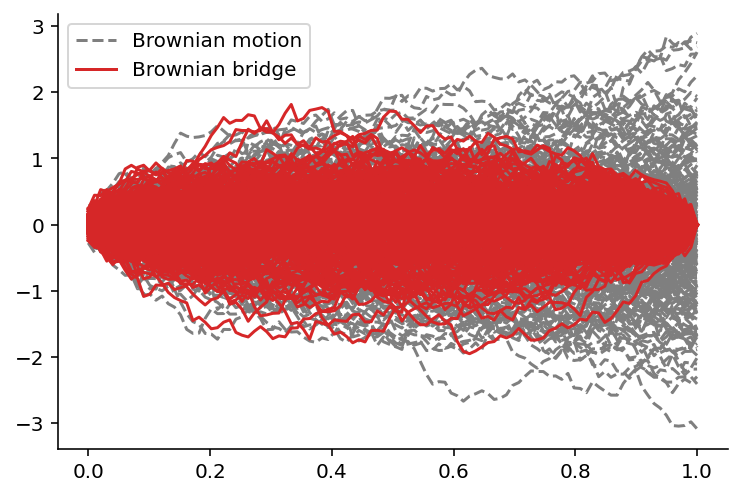

In [10]:
p1, *_ = plt.plot(timesteps, wt.T, c="tab:gray", linestyle="--", label="Brownian motion")
p2, *_ = plt.plot(timesteps, wb_t.T, c="tab:red", label="Brownian bridge")
ps = [p1, p2]
labels = [p.get_label() for p in ps]
plt.legend(ps, labels);

In [6]:
class AlphaMahalanobis:
    def __init__(self, alpha):
        self.alpha = alpha
    
    def fit(self, X):
        K = jnp.cov(X.T)
        self.mean = X.mean(axis=1)
        self.eigvals, self.eigvecs = jnp.linalg.eigh(K)
    
    def smooth(self, X):
        coeffs = self.eigvals / (self.eigvals + self.alpha)
        X_alpha = jnp.einsum("j,...m,mj,kj->...k", coeffs, X, self.eigvecs, self.eigvecs)
        return X_alpha

In [7]:
n_sims = 250
wt = sample_brownian_motion(key_bm, T, N, n_sims)
wb_t = sample_brownian_bridge(key_bb, T, N, n_sims)

In [8]:
metric_bm = AlphaMahalanobis(alpha=0.1)
metric_bm.fit(wt)
wt_alpha = metric_bm.smooth(wt)

metric_bb = AlphaMahalanobis(alpha=0.1)
metric_bb.fit(wb_t)
wb_t_alpha = metric_bb.smooth(wb_t)

Text(0.5, 1.0, 'Brownian bridge')

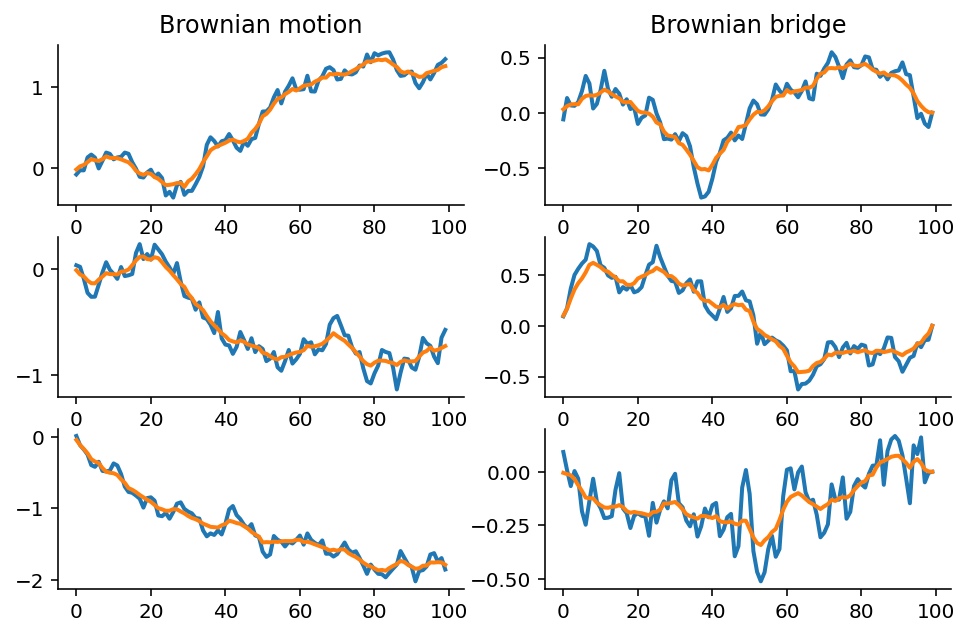

In [9]:
n_show = 3
indices = jax.random.choice(key, n_sims, (n_show,))

fig, ax = plt.subplots(3, 2, figsize=(8, 5))
for ax_row, ix in zip(ax, indices):
    ax0, ax1 = ax_row
    
    ax0.plot(wt[ix], linewidth=2)
    ax0.plot(wt_alpha[ix], linewidth=2)
    
    ax1.plot(wb_t[ix], linewidth=2)
    ax1.plot(wb_t_alpha[ix], linewidth=2)

ax[0,0].set_title("Brownian motion")
ax[0,1].set_title("Brownian bridge")